<a href="https://colab.research.google.com/github/soneyahossain/deep_learning_project/blob/master/modelExperimentWithDataset_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip DATA-2.zip


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import torch.utils.data
import json, os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class UVaBuildinglabel(torch.utils.data.Dataset):
    def __init__(self, image_path, annotation_filepath, transform = None):
        super(UVaBuildinglabel, self).__init__()
        
        print('Loading data...')
        data = pd.read_csv(annotation_filepath)              #json.load(open(annotation_filepath, 'rb'))
        
        self.transform = transforms.Compose(
        [transforms.Resize(320),  # 1. Resize smallest side to 256.
        transforms.RandomCrop(320), # 2. Crop random square of 224x224 pixels.
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
        
        self.image_path = image_path    # storing image path. 
        
        
        # get the image pixel values and labels
        image_ids = data.iloc[:, 0 ]
        label_ids = data.iloc[:, 1]
        label_names = data.iloc[:, 2]

        self.image_ids = data.iloc[:, 0 ] #[img_name for (img_id, img_name) in paired_id_names]
        self.image_labels = data.iloc[:, 1]   #[img_id for (img_id, img_name) in paired_id_names]
        self.image_classes= data.iloc[:, 2]


        #print(image_ids[0])
        #print(label_ids[0])
        #print(label_names)

        
    def __getitem__(self, index):
        image_name = self.image_ids[index]
        img_ = Image.open(open(os.path.join(self.image_path, image_name), 'rb'))
        img_ = img_.convert("RGB")
        if self.transform:
            img_ = self.transform(img_)
        label_ = self.image_labels[index]
        class_name= self.image_classes[index]
        return img_, label_,image_name,class_name
    
    def __len__(self):
        return len(self.image_ids)
       
      
# You can unnormalize the transformation of torch's transforms.normalize 
# with this custom transformation.
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


trainset = UVaBuildinglabel('DATA', 'trainSet-2.csv')
valset = UVaBuildinglabel('DATA', 'valSet-2.csv')

print("total training data",trainset.__len__())
print("total validation data",valset.__len__())

Loading data...
Loading data...
total training data 616
total validation data 153


In [0]:
def train_model(net, loss_fn, batchsize, trainset, valset, optimizer, num_epochs):

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize,shuffle=False, num_workers=2)

    train_accuracies = []; val_accuracies = []
    train_losses = []; val_losses = []
    
    N = num_epochs
    net=net.cuda()
    loss_fn = loss_fn.cuda()

    for epoch in range(N):  # loop over the dataset multiple times
        #print(epoch)
        correct = 0.0
        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, _, _ = data

            #print(inputs.shape)
            #print(labels.shape)
            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            #print(outputs.shape)
            #print(labels)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            max_scores, max_labels = outputs.max(1)

            #print(max_scores)
            #print(max_labels)

            correct += (max_labels == labels).sum().item()
            if (i+1) % (20) == 0:    # print every 10 mini-batches
                print('Train: [%d, %5d] loss: %.3f Accuracy: %.4f' %
                      (epoch + 1, i + 1, running_loss / i+1, correct / ((i+1)*batchsize)))
                running_loss = 0.0
        
        train_accuracies.append(correct / len(trainset))
        train_losses.append(running_loss / (i + 1))  

        net.eval()
        correct = 0
        running_loss = 0
        for i, data in enumerate(valloader, 0):
            inputs, labels, _, _ = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = net(inputs)
            running_loss += loss_fn(outputs, labels).item()

            max_scores, max_labels = outputs.max(1)
            correct += (max_labels == labels).sum().item()

        print('Validation: [%d, %5d] loss: %.3f Accuracy: %.4f' % 
              (epoch + 1, i + 1, running_loss / i+1, correct / ((i+1)*batchsize)))
        
        val_accuracies.append(correct / len(valset))
        val_losses.append(running_loss / (i + 1))
            
    print('Finished Training')


    plt.figure(figsize = (10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_losses, 'bo-', label = 'val-loss')
    plt.plot(train_losses, 'ro-', label = 'train-loss')
    plt.grid('on')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['validation', 'training'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, 'bo-', label = 'val-acc')
    plt.plot(train_accuracies, 'ro-', label = 'train-acc')
    plt.ylabel('accuracy')
    plt.grid('on')
    plt.xlabel('epoch')
    plt.legend(['validation', 'training'], loc='lower right')
    plt.show()

In [13]:
trainloader = torch.utils.data.DataLoader(trainset,shuffle=True)
no_images_per_class = torch.zeros(20)
for (i, (my_image, my_label,_,class_name)) in enumerate(trainloader):    
  no_images_per_class[my_label.item()]+=1  

print(no_images_per_class)
#weight for loss 
class_weights = 64/no_images_per_class   #as 64 is the miximum no of immage in a category
class_weights=torch.FloatTensor(class_weights)

print(class_weights)

tensor([19., 13., 55., 27., 64., 47., 47., 16., 20., 20., 20., 23., 39., 49.,
        28., 24., 17., 20., 24., 44.])
tensor([3.3684, 4.9231, 1.1636, 2.3704, 1.0000, 1.3617, 1.3617, 4.0000, 3.2000,
        3.2000, 3.2000, 2.7826, 1.6410, 1.3061, 2.2857, 2.6667, 3.7647, 3.2000,
        2.6667, 1.4545])


Train: [1,    20] loss: 4.179 Accuracy: 0.0625
Train: [1,    40] loss: 2.522 Accuracy: 0.0656
Train: [1,    60] loss: 1.940 Accuracy: 0.1125
Validation: [1,    20] loss: 3.587 Accuracy: 0.4625
Train: [2,    20] loss: 3.534 Accuracy: 0.5500
Train: [2,    40] loss: 2.183 Accuracy: 0.5563
Train: [2,    60] loss: 1.684 Accuracy: 0.5875
Validation: [2,    20] loss: 2.756 Accuracy: 0.6562
Train: [3,    20] loss: 2.746 Accuracy: 0.6312
Train: [3,    40] loss: 1.789 Accuracy: 0.7031
Train: [3,    60] loss: 1.460 Accuracy: 0.7250
Validation: [3,    20] loss: 2.034 Accuracy: 0.8000
Train: [4,    20] loss: 2.150 Accuracy: 0.8250
Train: [4,    40] loss: 1.480 Accuracy: 0.8531
Train: [4,    60] loss: 1.273 Accuracy: 0.8625
Validation: [4,    20] loss: 1.631 Accuracy: 0.8938
Train: [5,    20] loss: 1.644 Accuracy: 0.9062
Train: [5,    40] loss: 1.371 Accuracy: 0.9125
Train: [5,    60] loss: 1.195 Accuracy: 0.9229
Validation: [5,    20] loss: 1.371 Accuracy: 0.9313
Finished Training


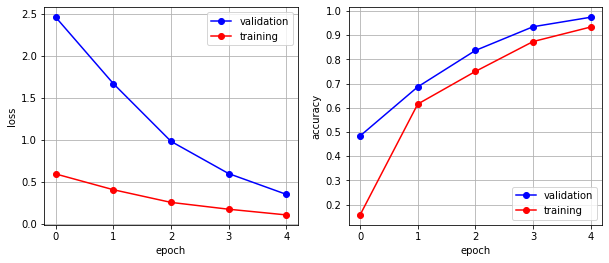

In [43]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

#weight=class_weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
resnet = models.resnet50(pretrained = True)

#print(len(trainset.image_classes))
resnet.fc = nn.Linear(2048, 20)
optimizer = optim.SGD(resnet.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(resnet, loss_fn, 8, trainset, valset, optimizer, 5)  

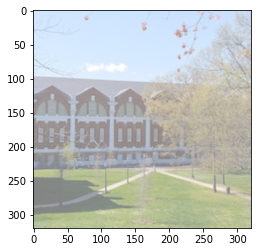

GroundTruth:  ('Memorial Gym',)
Predicted:  Memorial Gym


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

classes = ['Alderman Library', 'Alumni Hall', 'Aquatic & Fitness Center', 'Chemical Engineering Building', 'John Paul Jones Arena', 
           'Law School Building', 'Mechanical Building', 'Memorial Gym', 'Monroe Hall', 
           'Newcomb Hall', 'North Grounds Gym', 'Old Cabell Hall', 'Olsson Hall', 
           'Physics Building', 'Rice Hall', 'The Rotunda', 'Scott Stadium', 'Slaughter Recreation',
           'Thornton Hall', 'Wilsdorf Hall']

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = resnet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])


Train: [1,    20] loss: 8.800 Accuracy: 0.0625
Train: [1,    40] loss: 2.818 Accuracy: 0.2469
Train: [1,    60] loss: 1.720 Accuracy: 0.3583
Validation: [1,    20] loss: 1.755 Accuracy: 0.7688
Train: [2,    20] loss: 1.578 Accuracy: 0.8875
Train: [2,    40] loss: 1.188 Accuracy: 0.9062
Train: [2,    60] loss: 1.152 Accuracy: 0.9000
Validation: [2,    20] loss: 1.323 Accuracy: 0.9062
Train: [3,    20] loss: 1.270 Accuracy: 0.9437
Train: [3,    40] loss: 1.084 Accuracy: 0.9563
Train: [3,    60] loss: 1.088 Accuracy: 0.9521
Validation: [3,    20] loss: 1.180 Accuracy: 0.9313
Train: [4,    20] loss: 1.132 Accuracy: 0.9812
Train: [4,    40] loss: 1.070 Accuracy: 0.9750
Train: [4,    60] loss: 1.044 Accuracy: 0.9771
Validation: [4,    20] loss: 1.091 Accuracy: 0.9437
Train: [5,    20] loss: 1.089 Accuracy: 0.9875
Train: [5,    40] loss: 1.035 Accuracy: 0.9875
Train: [5,    60] loss: 1.036 Accuracy: 0.9833
Validation: [5,    20] loss: 1.084 Accuracy: 0.9375
Train: [6,    20] loss: 1.047 Accur

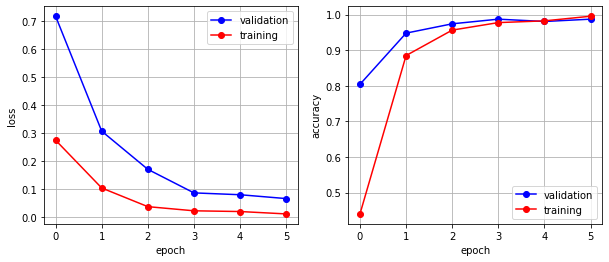

In [41]:
loss_fn = nn.CrossEntropyLoss()
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.fc = nn.Linear(2048, 20)
optimizer = optim.SGD(mobilenet.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(mobilenet, loss_fn, 8, trainset, valset, optimizer, 6)   #epoch 6 can give better results

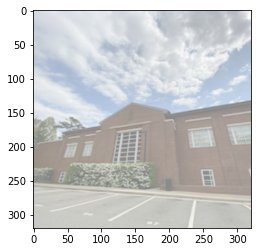

GroundTruth:  ('Aquatic & Fitness Center',)
Predicted:  Aquatic & Fitness Center


In [58]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = mobilenet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

Train: [1,    20] loss: 4.173 Accuracy: 0.1125
Train: [1,    40] loss: 2.323 Accuracy: 0.1750
Train: [1,    60] loss: 1.738 Accuracy: 0.2500
Train: [1,    80] loss: 1.436 Accuracy: 0.3094
Train: [1,   100] loss: 1.365 Accuracy: 0.3525
Train: [1,   120] loss: 1.261 Accuracy: 0.3771
Train: [1,   140] loss: 1.241 Accuracy: 0.4000
Validation: [1,    39] loss: 2.054 Accuracy: 0.7115
Train: [2,    20] loss: 2.039 Accuracy: 0.7000
Train: [2,    40] loss: 1.704 Accuracy: 0.6625
Train: [2,    60] loss: 1.289 Accuracy: 0.6958
Train: [2,    80] loss: 1.205 Accuracy: 0.7156
Train: [2,   100] loss: 1.157 Accuracy: 0.7150
Train: [2,   120] loss: 1.143 Accuracy: 0.7250
Train: [2,   140] loss: 1.118 Accuracy: 0.7304
Validation: [2,    39] loss: 1.724 Accuracy: 0.7500
Train: [3,    20] loss: 1.765 Accuracy: 0.7625
Train: [3,    40] loss: 1.270 Accuracy: 0.8063
Train: [3,    60] loss: 1.173 Accuracy: 0.8083
Train: [3,    80] loss: 1.115 Accuracy: 0.8187
Train: [3,   100] loss: 1.113 Accuracy: 0.8150
Tra

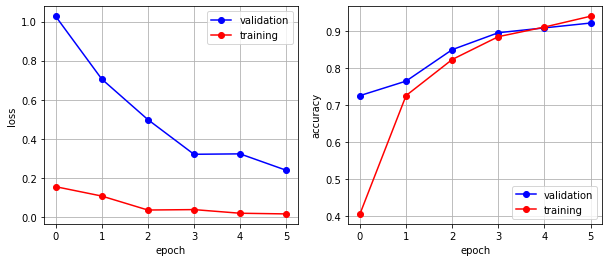

In [74]:
loss_fn = nn.CrossEntropyLoss()
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = nn.Linear(4096, 20)
optimizer = optim.SGD(alexnet.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(alexnet, loss_fn, 4, trainset, valset, optimizer, 6)  #epoch 6 worked better

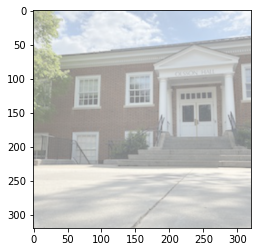

GroundTruth:  ('Olsson Hall',)
Predicted:  Olsson Hall


In [79]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = mobilenet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])